In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
from qvalue import estimate

In [2]:
fileroot='../../Data/'
figureroot=fileroot+'Figures/'

In [3]:
cd4=pd.read_pickle(fileroot+'CD4_sequences.pkl')
cd8=pd.read_pickle(fileroot+'CD8_sequences.pkl')

In [4]:
def single_chain_OR(cd4,cd8,feature):
    features4,counts4=np.unique(cd4[feature],return_counts=1)
    features8,counts8=np.unique(cd8[feature],return_counts=1)
    all_features=np.unique(np.hstack((features4,features8)))
    odds=np.zeros(len(all_features))
    pvalue=np.zeros(len(all_features))
    upper_ci=np.zeros(len(all_features))
    lower_ci=np.zeros(len(all_features))
    keep=[]
    for i,x in enumerate(all_features):
        if x in features4:
            a=counts4[np.where(features4==x)[0][0]]
        else:
            a=0
        if x in features8:
            b=counts8[np.where(features8==x)[0][0]]
        else:
            b=0
        c=np.sum(counts4)-a
        d=np.sum(counts8)-b
        if a+b>50:
            odds[i],pvalue[i]=stats.fisher_exact([[a,b],[c,d]])  
            lower_ci[i],upper_ci[i]=sm.stats.Table2x2(np.asarray([[a,b],[c,d]])).oddsratio_confint(alpha=0.05, method='normal')
            keep.append(i)
    all_features,odds,pvalue,lower_ci,upper_ci=all_features[keep],odds[keep],pvalue[keep],lower_ci[keep],upper_ci[keep]
    pvalue=pvalue*len(all_features)
    order=np.argsort(odds)
    return all_features[order],odds[order],pvalue[order],lower_ci[order],upper_ci[order]

In [5]:
def single_chain_plot(features,OR,p,lower_ci,upper_ci,figure):
    a4_dims = (8,4)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.errorbar(features,OR,[OR-lower_ci,upper_ci-OR],fmt='o',markersize=1,ecolor='black',color='black',zorder=2)
    plt.scatter(features,OR,color='black',s=50,marker='o')
    plt.scatter(features[p<.05],OR[p<.05],color='red',s=50,marker='o',zorder=3)
    plt.plot([-1,len(features)+1],[1,1],color='gray',linestyle='--',zorder=1)
    plt.xticks(rotation=90)
    plt.xlim([-1,len(features)])
    plt.ylim([0.25,2.75])
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    plt.close()

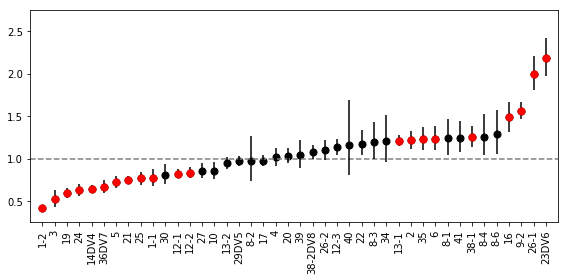

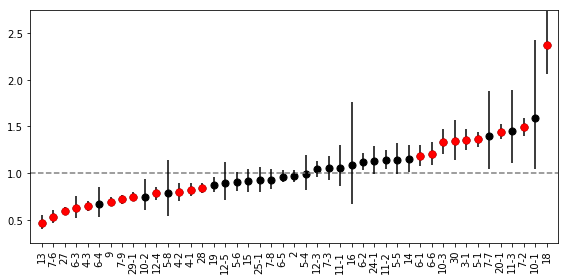

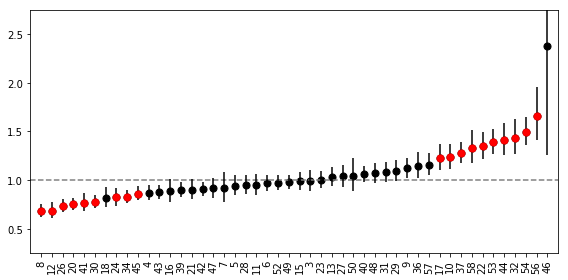

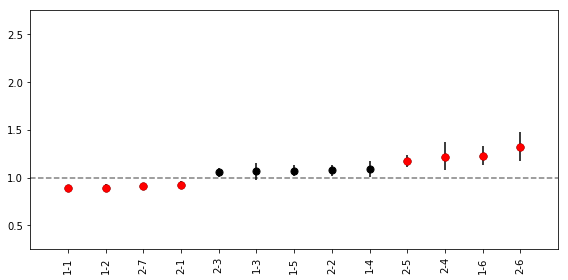

In [6]:
for (feature,figure) in zip (['Va','Vb','Ja','Jb'],['Figure2_A','Figure2_B','SFig1_A','SFig1B']):
    features,OR,p,lower_ci,upper_ci=single_chain_OR(cd4,cd8,feature)
    single_chain_plot(features,OR,p,lower_ci,upper_ci,figure)

In [7]:
def paired_chain_OR(cd4,cd8,feature1,feature2):
    features1=np.unique(np.hstack((np.unique(cd4[feature1]),np.unique(cd8[feature1]))))
    features2=np.unique(np.hstack((np.unique(cd4[feature2]),np.unique(cd8[feature2]))))

    fours=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    eights=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)

    for f1,f2 in zip(cd4[feature1],cd4[feature2]):
        fours[f2].loc[f1]+=1
    for f1,f2 in zip(cd8[feature1],cd8[feature2]):
        eights[f2].loc[f1]+=1

    odds=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    pvalue=pd.DataFrame(np.zeros((len(features1),len(features2))),columns=features2,index=features1)
    for f1 in features1:
        for f2 in features2:
            a=fours[f2].loc[f1]
            b=eights[f2].loc[f1]
            c=fours.sum().sum()-a
            d=eights.sum().sum()-b
            if a+b>50:
                odds[f2].loc[f1],pvalue[f2].loc[f1]=stats.fisher_exact([[a,b],[c,d]])  
    pvalue=pd.DataFrame(estimate(np.array(pvalue)),columns=odds.columns,index=odds.index)
    pvalue[(pvalue>.05) | (pvalue==0)]=0
    odds[pvalue==0]=0
    odds=odds[odds.columns[np.sum(odds,axis=0)!=0]]
    odds=odds[np.sum(odds,axis=1)!=0]
    pvalue=pvalue[odds.columns]
    pvalue=pvalue.loc[odds.index]
    odds[odds==0]=1
    odds[~np.isfinite(odds)]=1
    return odds

In [8]:
def paired_chain_plot(odds,figure):
    g=sns.clustermap(np.log10(odds),cmap='coolwarm',robust=0,center=0,method='single',vmin=-.9,vmax=.9)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    plt.close()

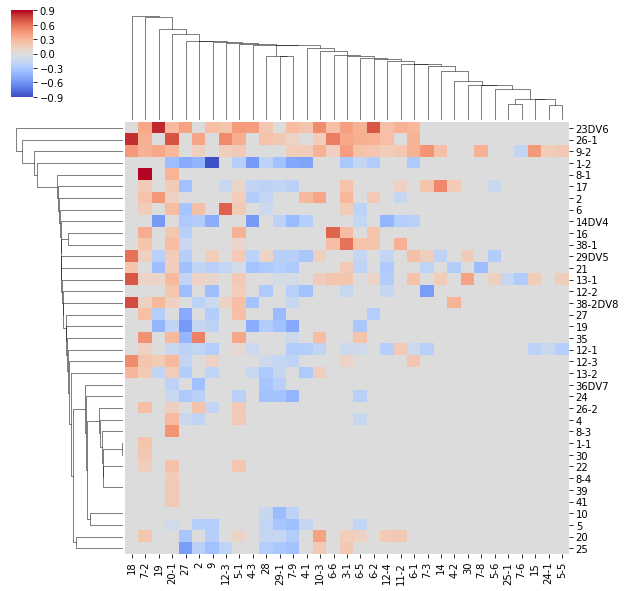

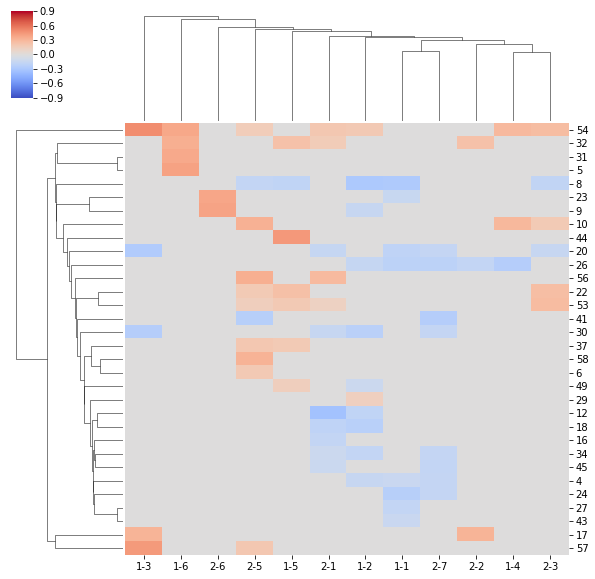

In [9]:
for (feature1,feature2,figure) in zip(['Va','Ja'],['Vb','Jb'],['Figure2_C','SFig1_C']):
    odds=paired_chain_OR(cd4,cd8,feature1,feature2)
    paired_chain_plot(odds,figure)

2.8705712096639322e-05


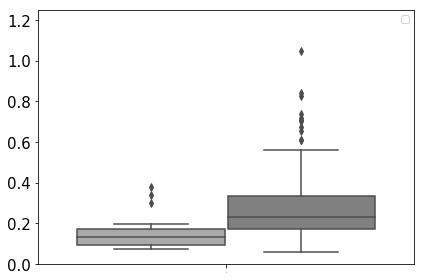

0.00029726352323891485


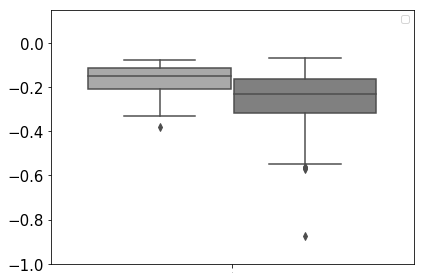

6.567220330037343e-07


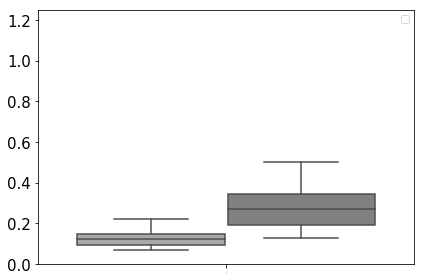

3.2125765456750555e-06


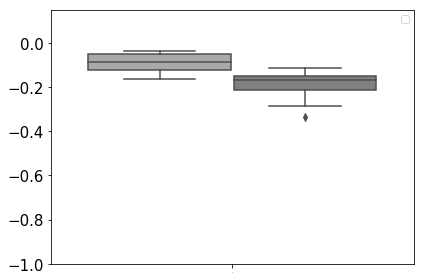

In [10]:
for feature1,feature2,figure1,figure2 in zip(['Va','Ja'],['Vb','Jb'],['Fig2_D','SFig2_D'],['Fig2_E','SFig2_E']):
    paired_odds=np.array(paired_chain_OR(cd4,cd8,feature1,feature2)).flatten()
    paired_odds=paired_odds[paired_odds!=1]
    df=pd.DataFrame(np.vstack((paired_odds,['Paired']*len(paired_odds))).T,columns=['OR','Dataset'])
    features,odds1,p,lower_ci,upper_ci=single_chain_OR(cd4,cd8,feature1)
    odds1=odds1[p<.05]
    features,odds2,p,lower_ci,upper_ci=single_chain_OR(cd4,cd8,feature2)
    odds2=odds2[p<.05]
    df=df.append(pd.DataFrame(np.vstack((np.hstack((odds1,odds2)),['Single']*len(np.hstack((odds1,odds2))))).T,columns=['OR','Dataset']))
    df.OR=np.log10(df.OR.astype(float))
    df['x']=[0]*df.shape[0]

    print(stats.mannwhitneyu(df[(df.OR>0) & (df.Dataset=='Paired')].OR,df[(df.OR>0) & (df.Dataset=='Single')].OR)[1])
    sns.boxplot(x='x',y='OR',hue='Dataset',data=df[df.OR>0],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
    if 'D' in figure1:
        plt.ylim([0,1.25])
    else:
        plt.ylim([0,.75])
    plt.legend('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()

    print(stats.mannwhitneyu(df[(df.OR<0) & (df.Dataset=='Paired')].OR,df[(df.OR<0) & (df.Dataset=='Single')].OR)[1])
    sns.boxplot(x='x',y='OR',hue='Dataset',data=df[df.OR<0],hue_order=['Single','Paired'],palette=['Darkgray','Gray'])
    if 'D' in figure1:
        plt.ylim([-1,.15])
    else:
        plt.ylim([-.5,.15])
    plt.legend('')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()
    plt.close()